# MW-M31 Post-Merger Remnant

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Shape" data-toc-modified-id="Shape-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Shape</a></span></li><li><span><a href="#Rotation" data-toc-modified-id="Rotation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Rotation</a></span></li><li><span><a href="#Velocity-dispersion" data-toc-modified-id="Velocity-dispersion-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Velocity dispersion</a></span></li><li><span><a href="#Mass-profile" data-toc-modified-id="Mass-profile-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Mass profile</a></span></li></ul></div>

## Setup

In [23]:
# import modules
import numpy as np
from numpy.linalg import norm, eig, eigh
import astropy.units as u
from astropy.constants import G

# import plotting modules
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import mpl_scatter_density

# Make the norm object to define the image stretch
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
norm = ImageNormalize(vmin=0., vmax=1000, stretch=LogStretch())

%matplotlib inline

In [2]:
# my modules
from galaxy.galaxy import Galaxy
from galaxy.centerofmass import CenterOfMass
from galaxy.massprofile import MassProfile
from galaxy.plots import Plots
from galaxy.timecourse import TimeCourse

In [3]:
from galaxy.remnant import Remnant

In [4]:
remnant = Remnant(usesql=True)

In [52]:
remnant.data, remnant.data.shape

(array([('M31', 2, 2.000e-05, 196.939, 24.1967, 139.881, 260.831  ,  -85.0969, -26.0921),
        ('M31', 2, 2.000e-05, 189.087, 20.2326, 146.165,  18.4025 ,   23.0247,  32.5107),
        ('M31', 2, 2.000e-05, 206.619, 19.0085, 122.444, -62.8166 , -162.355 , 181.913 ),
        ...,
        ('MW ', 3, 2.001e-05, 171.059, 13.8007, 128.251,  42.7172 ,  -34.8959,  64.3355),
        ('MW ', 3, 2.001e-05, 188.957, 23.4792, 147.111, 257.351  ,  -53.4361, -95.3574),
        ('MW ', 3, 2.001e-05, 189.534, 21.7683, 148.253,  -2.96004,   82.9176,  26.7174)],
       dtype=[('galname', '<U3'), ('type', 'u1'), ('m', '<f4'), ('x', '<f4'), ('y', '<f4'), ('z', '<f4'), ('vx', '<f4'), ('vy', '<f4'), ('vz', '<f4')]),
 (1120000,))

## Shape

In [6]:
com = CenterOfMass(remnant, ptype=None)

In [7]:
xyz, vxyz = com.center_com()

In [8]:
xyz.shape

(3, 1120000)

In [14]:
x,y,z = xyz
m = remnant.data['m']

In [15]:
x.shape, y.shape, z.shape, m.shape

((1120000,), (1120000,), (1120000,), (1120000,))

In [19]:
def I_tensor(m, x, y, z):
    """
    Args:
        m, x, y, z:
            1-D arrays with mass and coordinates (no units)
            
    Returns:
        3x3 array representing the moment of inertia tensor
    """
    
    # 3 moments of inertia for the diagonal
    Ixx = np.sum(m*(y**2 + z**2))
    Iyy = np.sum(m*(z**2 + x**2))
    Izz = np.sum(m*(x**2 + y**2))
    
    # 3 products of inertia for symmetric off-diagonals
    Ixy = Iyx = np.sum(m*x*y)
    Ixz = Izx = np.sum(m*x*z)
    Iyz = Izy = np.sum(m*y*z)

    # assemble the tensor and return it
    I = np.array([[Ixx, Ixy, Ixz],
                  [Iyx, Iyy, Iyz],
                  [Izx, Izy, Izz]])
    return I

In [20]:
I

array([[ 2.4364301e+04,  2.5513918e+02,  1.4297999e+03],
       [ 2.5513918e+02,  1.9706137e+04, -1.7131420e+01],
       [ 1.4297999e+03, -1.7131420e+01,  2.2022562e+04]], dtype=float32)

In [44]:
w, v = eigh(I)

C, B, A = w / np.max(w)
A, B, C

(1.0, 0.8524573, 0.78590083)

In [45]:
vC = v[:,0]
vB = v[:,1]
vA = v[:,2]
vA, vB, vC

(array([-0.90357435, -0.04176731, -0.42639056], dtype=float32),
 array([-0.42273688, -0.07480813,  0.9031596 ], dtype=float32),
 array([ 0.06962003, -0.9963229 , -0.04993812], dtype=float32))

In [39]:
vA = v[2]
np.sqrt(np.sum([vi**2 for vi in vA]))

1.000000010040957

In [51]:
vC @ vC

1.0

In [9]:
L, pos, v = com.angular_momentum()
L

array([ 1.6242846e+08, -7.1358522e+08, -4.9119174e+08], dtype=float32)

In [10]:
xyz_rot, vxyz_rot = com.rotate_frame()

/home/colin/.pyenv/versions/miniconda3-4.2.12/envs/400b/lib/python3.6/site-packages/mpl_scatter_density/generic_density_artist.py:74: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/colin/.pyenv/versions/miniconda3-4.2.12/envs/400b/lib/python3.6/site-packages/mpl_scatter_density/generic_density_artist.py:79: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


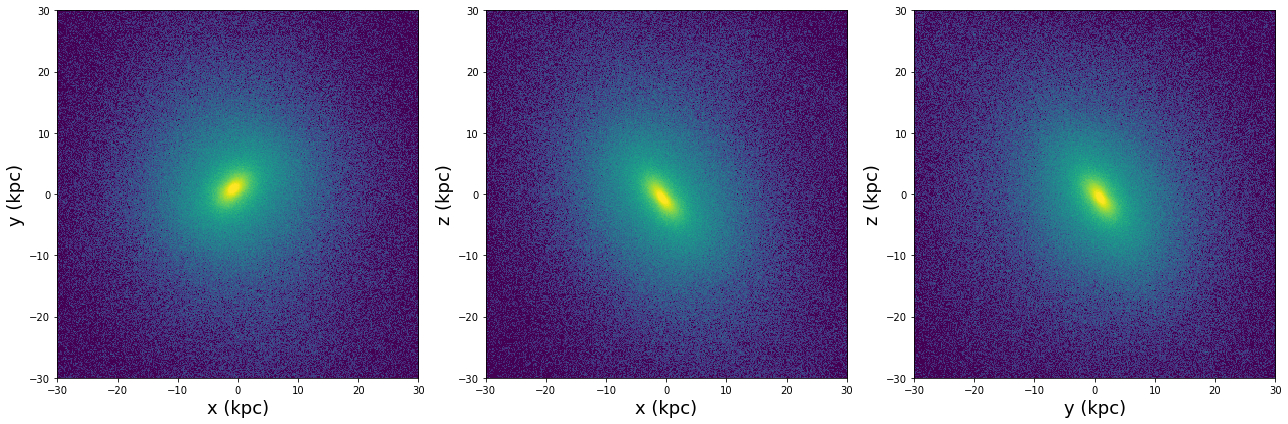

In [11]:
fig = plt.figure(figsize=(18,6))

lim = 30 # axes +/- lim
fontsize = 18 # for labels

# left plot x-y
ax0 = fig.add_subplot(1, 3, 1, projection='scatter_density')
ax0.scatter_density(xyz_rot[0], xyz_rot[1], norm=norm)

ax0.set_xlim(-lim, lim)
ax0.set_ylim(-lim, lim)

ax0.set_xlabel('x (kpc)', fontsize=fontsize)
ax0.set_ylabel('y (kpc)', fontsize=fontsize)

# mid plot x-z
ax1 = fig.add_subplot(1, 3, 2, projection='scatter_density')
ax1.scatter_density(xyz_rot[0], xyz_rot[2], norm=norm)

ax1.set_xlim(-lim, lim)
ax1.set_ylim(-lim, lim)

ax1.set_xlabel('x (kpc)', fontsize=fontsize)
ax1.set_ylabel('z (kpc)', fontsize=fontsize)

# right plot y-z
ax2 = fig.add_subplot(1, 3, 3, projection='scatter_density')
ax2.scatter_density(xyz_rot[1], xyz_rot[2], norm=norm)

ax2.set_xlim(-lim, lim)
ax2.set_ylim(-lim, lim)

ax2.set_xlabel('y (kpc)', fontsize=fontsize)
ax2.set_ylabel('z (kpc)', fontsize=fontsize);

#adjust tick label font size
label_size = 16
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size
plt.tight_layout()
plt.savefig('remnant_shape.pdf', rasterized=True, dpi=350);

## Rotation

/home/colin/.pyenv/versions/miniconda3-4.2.12/envs/400b/lib/python3.6/site-packages/mpl_scatter_density/generic_density_artist.py:74: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/colin/.pyenv/versions/miniconda3-4.2.12/envs/400b/lib/python3.6/site-packages/mpl_scatter_density/generic_density_artist.py:79: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


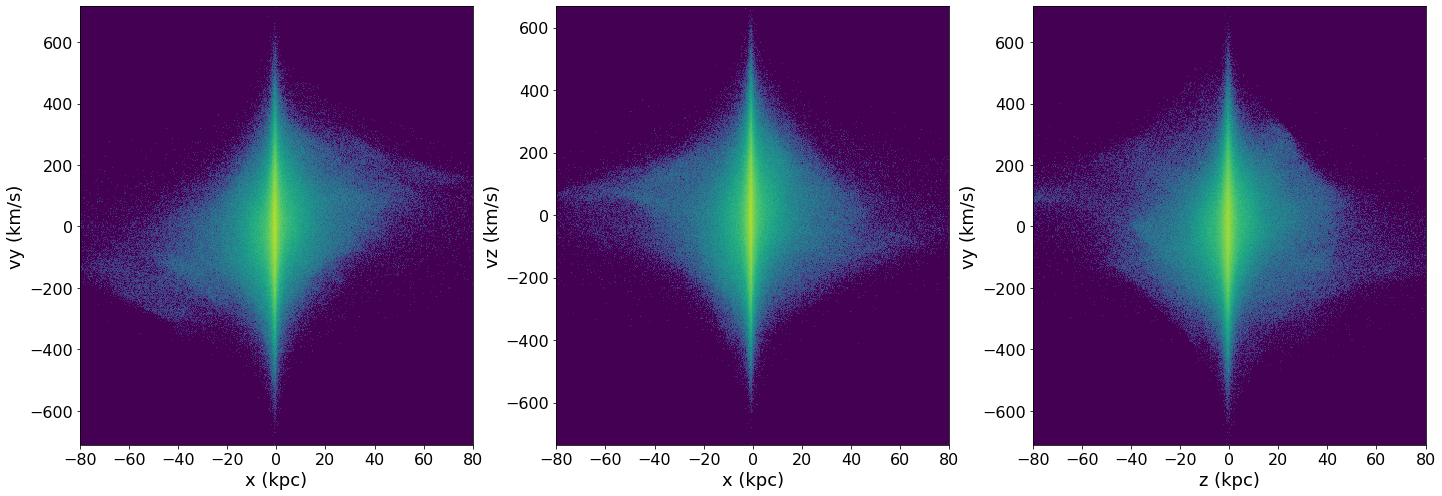

In [12]:
fig = plt.figure(figsize=(20,7))

lim = 80 # axes +/- lim
fontsize = 18 # for labels

# left plot x-vy
ax0 = fig.add_subplot(1, 3, 1, projection='scatter_density')
ax0.scatter_density(xyz_rot[0], vxyz_rot[1], norm=norm)

ax0.set_xlim(-lim, lim)
# ax0.set_ylim(-lim, lim)

ax0.set_xlabel('x (kpc)', fontsize=fontsize)
ax0.set_ylabel('vy (km/s)', fontsize=fontsize)

# mid plot x-vz
ax1 = fig.add_subplot(1, 3, 2, projection='scatter_density')
ax1.scatter_density(xyz_rot[0], vxyz_rot[2], norm=norm)

ax1.set_xlim(-lim, lim)
# ax1.set_ylim(-lim, lim)

ax1.set_xlabel('x (kpc)', fontsize=fontsize)
ax1.set_ylabel('vz (km/s)', fontsize=fontsize);

# right plot z-vy
ax1 = fig.add_subplot(1, 3, 3, projection='scatter_density')
ax1.scatter_density(xyz_rot[2], vxyz_rot[1], norm=norm)

ax1.set_xlim(-lim, lim)
# ax1.set_ylim(-lim, lim)

ax1.set_xlabel('z (kpc)', fontsize=fontsize)
ax1.set_ylabel('vy (km/s)', fontsize=fontsize);
plt.tight_layout()
plt.savefig('remnant_phase.pdf', rasterized=True, dpi=350);

/home/colin/.pyenv/versions/miniconda3-4.2.12/envs/400b/lib/python3.6/site-packages/mpl_scatter_density/generic_density_artist.py:74: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/colin/.pyenv/versions/miniconda3-4.2.12/envs/400b/lib/python3.6/site-packages/mpl_scatter_density/generic_density_artist.py:79: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


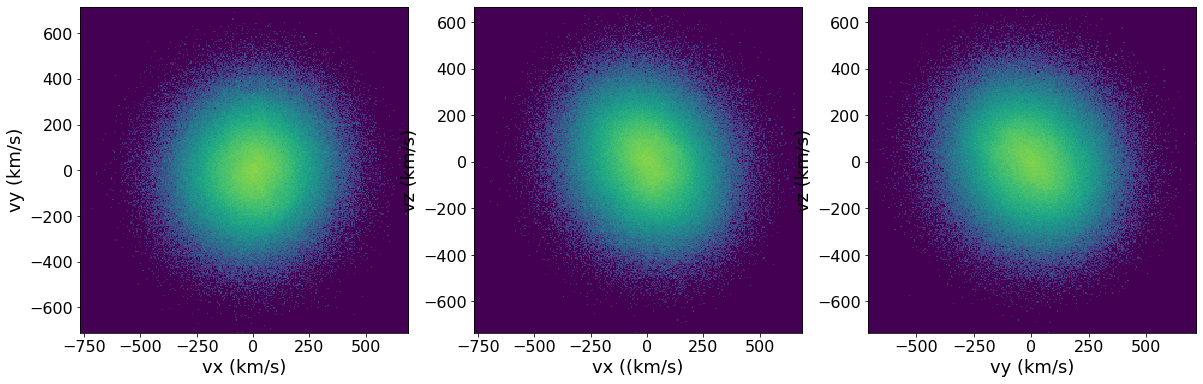

In [13]:
fig = plt.figure(figsize=(20,6))

lim = 80 # axes +/- lim
fontsize = 18 # for labels

# left plot x-vy
ax0 = fig.add_subplot(1, 3, 1, projection='scatter_density')
ax0.scatter_density(vxyz_rot[0], vxyz_rot[1], norm=norm)

# ax0.set_xlim(-lim, lim)
# ax0.set_ylim(-lim, lim)

ax0.set_xlabel('vx (km/s)', fontsize=fontsize)
ax0.set_ylabel('vy (km/s)', fontsize=fontsize)

# mid plot x-vz
ax1 = fig.add_subplot(1, 3, 2, projection='scatter_density')
ax1.scatter_density(vxyz_rot[0], vxyz_rot[2], norm=norm)

# ax1.set_xlim(-lim, lim)
# ax1.set_ylim(-lim, lim)

ax1.set_xlabel('vx ((km/s)', fontsize=fontsize)
ax1.set_ylabel('vz (km/s)', fontsize=fontsize);

# right plot z-vy
ax1 = fig.add_subplot(1, 3, 3, projection='scatter_density')
ax1.scatter_density(vxyz_rot[1], vxyz_rot[2], norm=norm)

# ax1.set_xlim(-lim, lim)
# ax1.set_ylim(-lim, lim)

ax1.set_xlabel('vy (km/s)', fontsize=fontsize)
ax1.set_ylabel('vz (km/s)', fontsize=fontsize);


## Velocity dispersion

## Mass profile